# Solar panel data

Import libraries:

In [2]:
%config InlineBackend.figure_format = 'retina'
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.stats import linregress
import numpy as np

## Load data

Load raw data, then compute the actual voltages and currents, the power and impedance, and the noises.

There is an index file *data/index.dat* with information about each data acquisition, and many data files *data/?.dat* with each acquisition. There is a file *data/labjack_noise* with data acquired with the input channels disconnected.

In [3]:
index = pd.read_csv('data/index.dat', sep = '\t')
index.Time = [datetime.strptime(t, '%Y-%m-%d_%H:%M:%S') for t in index.Time]

data = []
for name in index.File:
    data.append(pd.read_csv('data/'+name, sep = '\s+'))

noise = pd.read_csv('data/labjack_noise.txt', sep = '\s+')[1:]

The offset in the V1 channel is -0.0124094761232 +/- 4.41952093814e-05
The offset in the V2 channel is -0.0115648835879 +/- 4.63650941235e-05


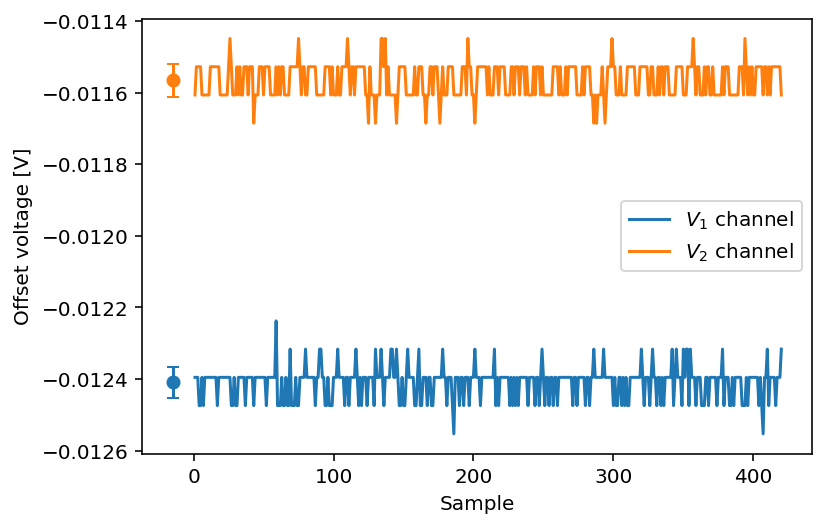

In [4]:
mean_v1 = noise['Voltage'].mean() # Offset in the 'voltage' channel
mean_v2 = noise['Current'].mean() # Offset in the 'current' channel
sigma_v1 = np.std(noise['Voltage'].values) # Standard deviation
sigma_v2 = np.std(noise['Current'].values) # Standard deviation
print('''\
The offset in the V1 channel is {0} +/- {1}
The offset in the V2 channel is {2} +/- {3}'''.format(mean_v1, sigma_v1, mean_v2, sigma_v2))

p1 = plt.plot(noise.Voltage, label = '$V_1$ channel')
p2 = plt.plot(noise.Current, label = '$V_2$ channel')
plt.xlabel('Sample')
plt.ylabel('Offset voltage [V]')
plt.legend()
plt.errorbar(-15, mean_v1, yerr = sigma_v1, fmt='o', capsize = 3, color = p1[0].get_color())
plt.errorbar(-15, mean_v2, yerr = sigma_v2, fmt='o', capsize = 3, color = p2[0].get_color())
plt.savefig('plots/noise.pdf')
plt.show()

In [5]:
sigma_V = 11 * sigma_v1
sigma_I = 100 * sigma_v2
for d in data:
    d.Voltage = 11 * (d.Voltage - mean_v1)
    d.Current = 100 * (d.Current - mean_v2)
    d['Impedance'] = d.Voltage / d.Current
    d['Power'] = d.Voltage * d.Current
    d['sigma_Power'] = np.sqrt((sigma_I * d.Voltage) ** 2 + (sigma_V * d.Current) ** 2)
    d['sigma_Impedance'] = np.sqrt((sigma_I * d.Voltage / (d.Current**2)) ** 2 + (sigma_V / d.Current) ** 2)

## Plot

Plot all *I-V* curves individually:

In [6]:
for i, row in index.iterrows():
    plt.clf()
    plt.plot(data[i].Voltage, data[i].Current, '-', alpha = .3, marker = '.')
    plt.xlabel('Voltage [V]')
    plt.ylabel('Current [A]')
    plt.title('Panel {}, {}'.format(row.Panel_ID, row.Side))
    plt.grid(ls = ':')
    plt.savefig('plots/{}_IV.pdf'.format(i + 1), bbox_inches = 'tight')

Plot all Power-Impedance curves individually:

In [7]:
for i, row in index.iterrows():
    plt.clf()
    plt.plot(data[i].Impedance, data[i].Power, '-', alpha = .3, marker = '.')
    plt.xlabel('Impedance [$\Omega$]')
    plt.ylabel('Power [W]')
    plt.title('Panel {}, {}'.format(row.Panel_ID, row.Side))
    plt.grid(ls = ':')
    plt.savefig('plots/{}_ZP.pdf'.format(i + 1), bbox_inches = 'tight')

Plot superimposed *I-V* or *Z-P* curves for the reference panel:

In [8]:
# I-V curves
plt.clf()
for i, row in index[(index.Panel_ID == 89) & (index.Side == 'Front')].iterrows():
    plt.plot(data[i].Voltage, data[i].Current, '.', alpha = .4, 
             label = '{}:{:02d}'.format(row.Time.hour, row.Time.minute))
plt.xlabel('Voltage [V]')
plt.ylabel('Current [A]')
plt.title('Panel 89, Front')
plt.grid(ls = ':')
plt.legend()
plt.savefig('plots/ref_IV.pdf', bbox_inches = 'tight')

# Z-P curves
plt.clf()
for i, row in index[(index.Panel_ID == 89) & (index.Side == 'Front')].iterrows():
    plt.plot(data[i].Impedance, data[i].Power, '.', alpha = .4,
             label = '{}:{:02d}'.format(row.Time.hour, row.Time.minute))
plt.xlabel('Impedance [$\Omega$]')
plt.ylabel('Power [W]')
plt.title('Panel 89, Front')
plt.grid(ls = ':')
plt.legend()
plt.savefig('plots/ref_ZP.pdf', bbox_inches = 'tight')
plt.xlim(2,5)
plt.savefig('plots/ref_ZP_zoom.pdf', dpi = 200, bbox_inches = 'tight')

Plot all superimposed *I-V* curves, and *Z-P* curves (article style):

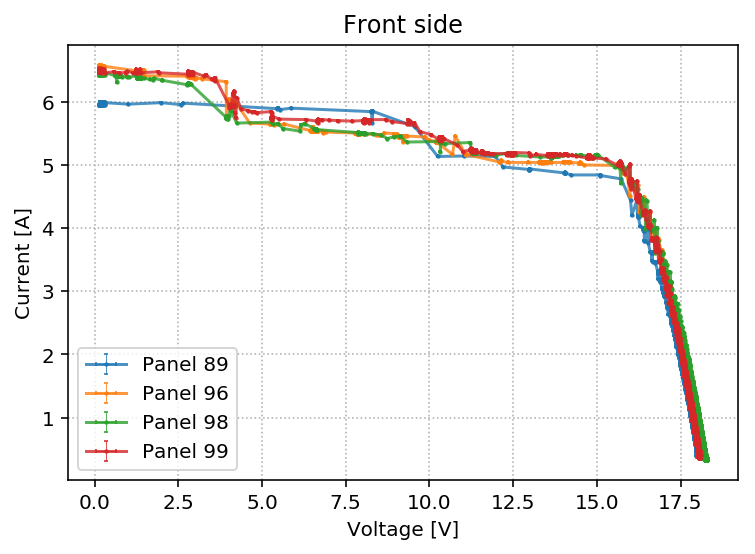

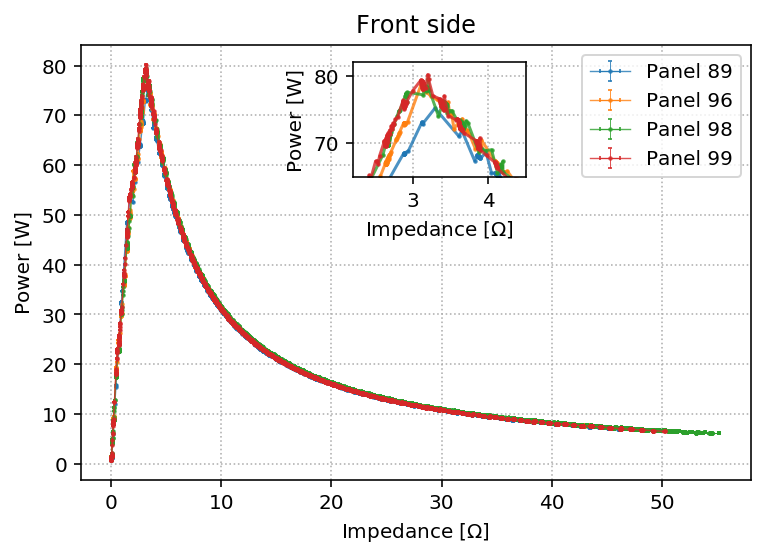

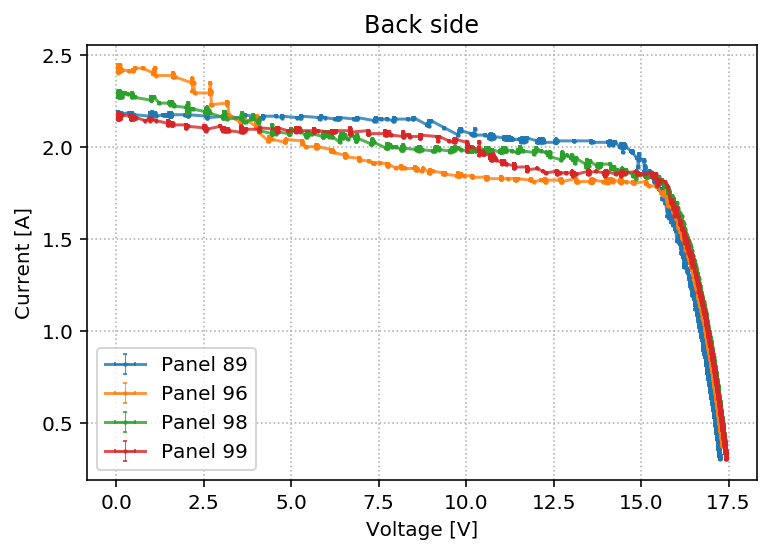

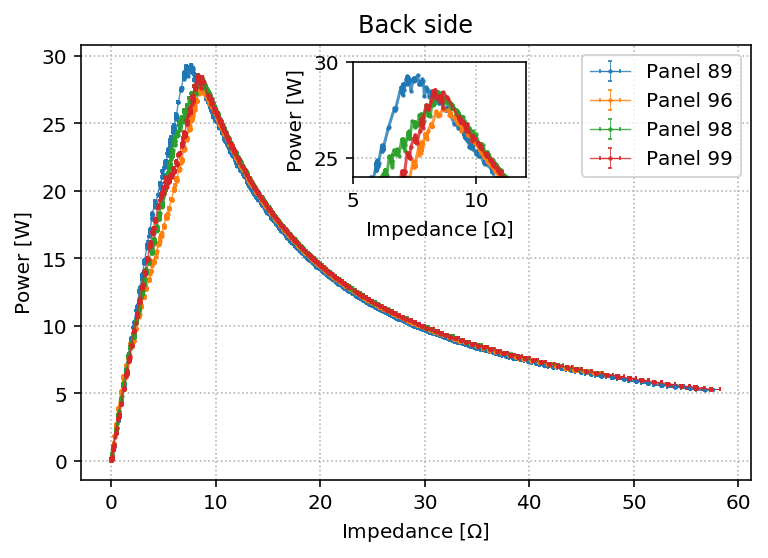

In [9]:
for side in ['Front', 'Back']:
    # I-V curves
    plt.clf()
    for i, row in index[index.Side == side].drop_duplicates(subset = 'Panel_ID').sort_values(['Panel_ID']).iterrows():
        d = data[i].drop_duplicates(subset = ['Current', 'Voltage']).sort_values(['Voltage'])
        plt.errorbar(d.Voltage, d.Current, xerr = sigma_V, yerr = sigma_I, 
                     fmt = '.-', alpha = .8, elinewidth = .5, markersize = 2.5, capsize = 1,
                     label = 'Panel {}'.format(row.Panel_ID))
    plt.xlabel('Voltage [V]')
    plt.ylabel('Current [A]')
    plt.title('{} side'.format(side))
    plt.grid(ls = ':')
    plt.legend()
    plt.savefig('plots/all_IV_{}.pdf'.format(side), bbox_inches = 'tight')
    plt.show()
    
    # Z-P curves
    plt.clf()
    for i, row in index[index.Side == side].drop_duplicates(subset = 'Panel_ID').sort_values(['Panel_ID']).iterrows():
        d = data[i].drop_duplicates(subset = ['Impedance', 'Power']).sort_values(['Impedance'])
        plt.errorbar(d.Impedance, d.Power, xerr = d.sigma_Impedance, yerr = d.sigma_Power, 
                     fmt = '.-', alpha = .8, elinewidth = .5, markersize = 2.5, capsize = 1, lw=.7, 
                     label = 'Panel {}'.format(row.Panel_ID))
    plt.xlabel('Impedance [$\Omega$]')
    plt.ylabel('Power [W]')
    plt.title('{} side'.format(side))
    plt.grid(ls = ':')
    plt.legend()
    
    # Inset axes over the main axes
    a = plt.axes([.44, .65, .2, .2])
    for i, row in index[index.Side == side].drop_duplicates(subset = 'Panel_ID').sort_values(['Panel_ID']).iterrows():
        d = data[i].drop_duplicates(subset = ['Impedance', 'Power']).sort_values(['Impedance'])
        plt.errorbar(d.Impedance, d.Power, xerr = d.sigma_Impedance, yerr = d.sigma_Power, 
                     fmt = '.-', markersize = 2.5, alpha = .8, elinewidth = 1,
                     label = 'Panel {}'.format(row.Panel_ID))
    plt.xlabel('Impedance [$\Omega$]')
    plt.ylabel('Power [W]')
    plt.grid(ls = ':')
    if side == 'Front':
        plt.xlim([2.2, 4.5])
        plt.ylim([65, 82])
    else:
        plt.xlim([5,12])
        plt.ylim([24, 30])
   
    plt.savefig('plots/all_ZP_{}.pdf'.format(side), bbox_inches = 'tight')
    plt.show()

Same plots, talk style:

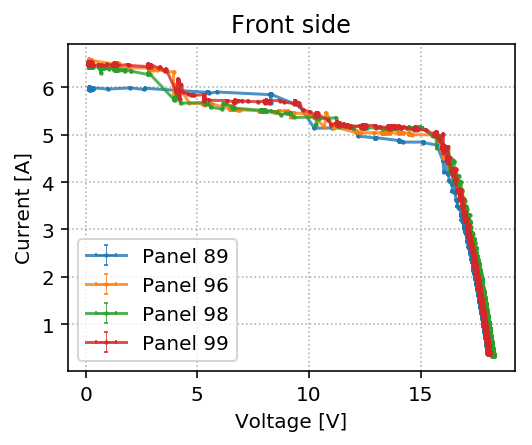

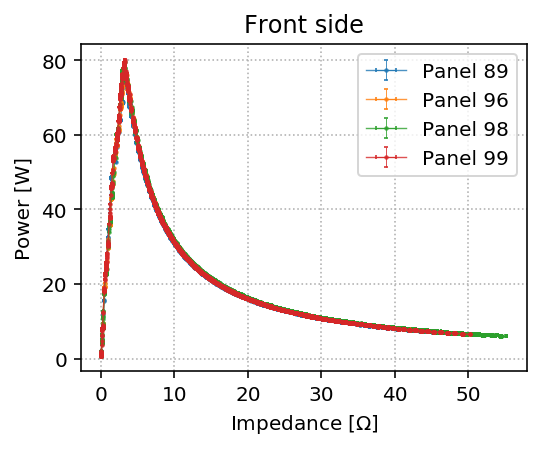

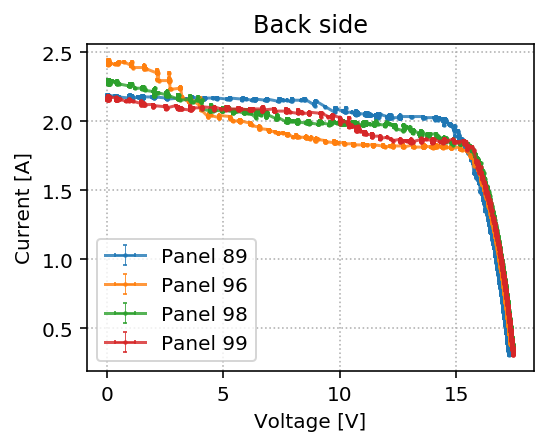

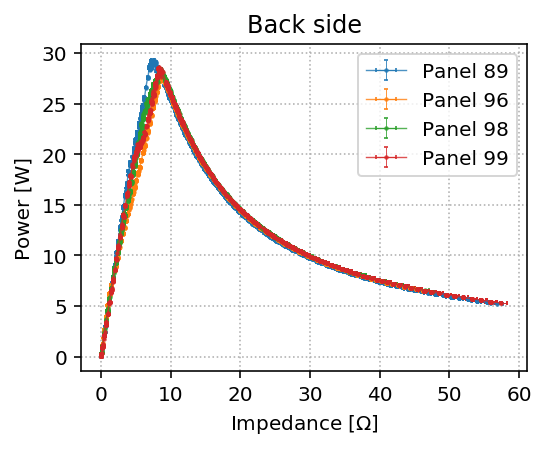

In [13]:
for side in ['Front', 'Back']:
    # I-V curves
    plt.clf()
    plt.figure(figsize=(4,3)) # Make a smaller figure so the letters are bigger
    for i, row in index[index.Side == side].drop_duplicates(subset = 'Panel_ID').sort_values(['Panel_ID']).iterrows():
        d = data[i].drop_duplicates(subset = ['Current', 'Voltage']).sort_values(['Voltage'])
        plt.errorbar(d.Voltage, d.Current, xerr = sigma_V, yerr = sigma_I, 
                     fmt = '.-', alpha = .8, elinewidth = .5, markersize = 2.5, capsize = 1,
                     label = 'Panel {}'.format(row.Panel_ID))
    plt.xlabel('Voltage [V]')
    plt.ylabel('Current [A]')
    plt.title('{} side'.format(side))
    plt.grid(ls = ':')
    plt.legend()
    plt.savefig('plots/all_IV_{}_talk.pdf'.format(side), bbox_inches = 'tight')
    plt.show()
    
    # Z-P curves
    plt.clf()
    plt.figure(figsize=(4,3))
    for i, row in index[index.Side == side].drop_duplicates(subset = 'Panel_ID').sort_values(['Panel_ID']).iterrows():
        d = data[i].drop_duplicates(subset = ['Impedance', 'Power']).sort_values(['Impedance'])
        plt.errorbar(d.Impedance, d.Power, xerr = d.sigma_Impedance, yerr = d.sigma_Power, 
                     fmt = '.-', alpha = .8, elinewidth = .5, markersize = 2.5, capsize = 1, lw=.7, 
                     label = 'Panel {}'.format(row.Panel_ID))
    plt.xlabel('Impedance [$\Omega$]')
    plt.ylabel('Power [W]')
    plt.title('{} side'.format(side))
    plt.grid(ls = ':')
    plt.legend()
   
    plt.savefig('plots/all_ZP_{}_talk.pdf'.format(side), bbox_inches = 'tight')
    plt.show()

## Parameter estimation

Get $V_{OC}$, $I_{SC}$, $V_{mp}$, $R_{mp}$ (i.e. open circuit voltage, short circuit current, maximum power voltage, maximum power resistance).

Estimate $R_s$ and $R_{sh}$ (i.e. series and shunt resistance) from:

$$R_s = -\frac{d V}{d I}\bigg|_{OC} $$

$$ R_{sh} = -\frac{d V}{d I}\bigg|_{SC}$$

In [11]:
parameters = pd.DataFrame(index = index.drop_duplicates(subset = 'Panel_ID').Panel_ID)
V_oc, I_sc, V_mp, dVmp_p, dVmp_m, R_mp, dRmp_p, dRmp_m, R_s, R_sh, P_max = [], [], [], [], [], [], [], [], [], [], []
for i in parameters.index: # i = Panel ID
    j = index[(index.Panel_ID == i) & (index.Side == 'Front')].index[-1] # j = File ID
    
    V_oc.append(data[j].Voltage.max())
    I_sc.append(data[j].Current.max())
    V_mp.append(data[j].Voltage[data[j].Power.idxmax()])
    R_mp.append(data[j].Impedance[data[j].Power.idxmax()])
    P_max.append(data[j].Power.max())
    
    opt  = data[j][data[j].Power > .9 * data[j].Power.max()] # > 90% optimal region
    dRmp_p.append(opt.Impedance.max() - R_mp[-1])
    dRmp_m.append(R_mp[-1] - opt.Impedance.min())
    dVmp_p.append(opt.Voltage.max() - V_mp[-1])
    dVmp_m.append(V_mp[-1] - opt.Voltage.min())
    
    SC = data[j][data[j].Voltage < 3] # Short circuit
    OC = data[j][data[j].Current < 1] # Open circuit
    R_s.append(- linregress(OC.Current, OC.Voltage).slope)
    R_sh.append(- linregress(SC.Current, SC.Voltage).slope)
    
parameters['V_oc'] = V_oc
parameters['I_sc'] = I_sc
parameters['V_mp'] = V_mp
parameters['dVmp_p'] = dVmp_p
parameters['dVmp_m'] = dVmp_m
parameters['R_mp'] = R_mp
parameters['dRmp_p'] = dRmp_p
parameters['dRmp_m'] = dRmp_m
parameters['R_s'] = R_s
parameters['R_sh'] = R_sh
parameters['P_max'] = P_max
pd.options.display.float_format = '{:,.2f}'.format

parameters

V_oc  I_sc  V_mp  dVmp_p  dVmp_m  R_mp  dRmp_p  dRmp_m  R_s  R_sh  \
Panel_ID                                                                      
89       17.98  6.14 15.32    0.84    1.11  3.12    0.73    0.27 0.36 27.67   
96       18.17  6.59 15.62    0.78    1.57  3.10    0.65    0.32 0.25 15.96   
98       18.30  6.49 15.95    0.55    2.07  3.20    0.53    0.51 0.44 11.93   
99       18.10  6.53 16.00    0.25    1.99  3.19    0.44    0.48 0.33 17.57   

          P_max  
Panel_ID         
89        75.31  
96        78.62  
98        79.52  
99        80.14